In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [6]:
#Step 1: Load Each Table Correctly
# Load each sheet using the correct names
df_customers = sheets['customers']
df_genders = sheets['genders']
df_cities = sheets['cities']
df_transactions = sheets['transactions']
df_branches = sheets['branches']
df_merchants = sheets['merchants']

# Display the first few rows of each DataFrame
print(df_customers.head())
print(df_transactions.head())  # Checking transactions data


   customer_id  join_date  city_id  gender_id
0            1 2022-01-08        7          1
1            2 2023-05-02       20          2
2            3 2023-05-14       15          1
3            4 2022-11-25       11          2
4            5 2023-04-26        8          1
   transaction_id  customer_id transaction_date transaction_status  \
0               1          733       2024-05-11         subscribed   
1               2          631       2023-05-15             burned   
2               3          309       2022-11-13         subscribed   
3               4          695       2024-01-26         subscribed   
4               5          288       2022-10-12             burned   

  coupon_name  burn_date  branch_id  
0     uNY-568        NaT          7  
1     kBx-219 2023-06-04          5  
2     PLG-122        NaT          7  
3     Wzf-897        NaT          2  
4     qGb-428 2022-11-20          6  


In [7]:
#Step 2: Merge the Tables
# Merge Customers with Genders (on gender_id)
df_merged = df_customers.merge(df_genders, on='gender_id', how='left')

# Merge with Cities (on city_id)
df_merged = df_merged.merge(df_cities, on='city_id', how='left')

# Merge with Transactions (on customer_id)
df_merged = df_merged.merge(df_transactions, on='customer_id', how='left')

# Merge with Branches (on branch_id)
df_merged = df_merged.merge(df_branches, on='branch_id', how='left')

# Merge with Merchants (on merchant_id)
df_merged = df_merged.merge(df_merchants, on='merchant_id', how='left')

# Show merged data
print(df_merged.head())


   customer_id  join_date  city_id  gender_id gender_name city_name  \
0            1 2022-01-08        7          1        Male  Mansoura   
1            1 2022-01-08        7          1        Male  Mansoura   
2            1 2022-01-08        7          1        Male  Mansoura   
3            1 2022-01-08        7          1        Male  Mansoura   
4            1 2022-01-08        7          1        Male  Mansoura   

   transaction_id transaction_date transaction_status coupon_name  burn_date  \
0           178.0       2022-07-30         subscribed     SrP-866        NaT   
1           257.0       2022-09-19             burned     krI-075 2022-11-05   
2          1652.0       2022-06-09             burned     quk-137 2022-07-19   
3          1929.0       2022-07-30             burned     QiG-754 2022-10-18   
4          2352.0       2023-03-24         subscribed     OtC-985        NaT   

   branch_id  merchant_id                merchant_name  
0        8.0         20.0          

In [16]:
# 🟢 Step 3: Feature Engineering (Adding Customer Behavior Features)
customer_transactions = df_merged.groupby('customer_id').agg(
    num_transactions=('transaction_id', 'count'),  # Total transactions per customer
    num_burnt=('transaction_status', lambda x: (x == 'burnt').sum()),  # Burnt transactions
    num_claimed=('transaction_status', lambda x: (x == 'claimed').sum())  # Claimed transactions
).reset_index()

# Compute burn rate (burned / total transactions)
customer_transactions['burn_rate'] = customer_transactions['num_burnt'] / customer_transactions['num_transactions']
customer_transactions['burn_rate'].fillna(0, inplace=True)  # Replace NaN with 0

# Merge with main dataset
df_merged = df_merged.merge(customer_transactions, on='customer_id', how='left')

# 🟢 Step 4: Selecting Features for Clustering
features = df_merged[['city_id', 'gender_id', 'burn_rate', 'num_transactions']]

# Convert categorical data to numerical (if needed)
features['gender_id'] = features['gender_id'].astype('category').cat.codes

# Display the final selected features
print(features.head())


   city_id  gender_id  burn_rate  num_transactions
0        7          0        0.0                 7
1        7          0        0.0                 7
2        7          0        0.0                 7
3        7          0        0.0                 7
4        7          0        0.0                 7


<ipython-input-16-160f31217e8d>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_transactions['burn_rate'].fillna(0, inplace=True)  # Replace NaN with 0
<ipython-input-16-160f31217e8d>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['gender_id'] = features['gender_id

In [17]:
# Step 4: Scale the Features
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)

# Show scaled data
print(df_scaled.head())


    city_id  gender_id  burn_rate  num_transactions
0 -0.527659  -0.973801        0.0          0.410711
1 -0.527659  -0.973801        0.0          0.410711
2 -0.527659  -0.973801        0.0          0.410711
3 -0.527659  -0.973801        0.0          0.410711
4 -0.527659  -0.973801        0.0          0.410711


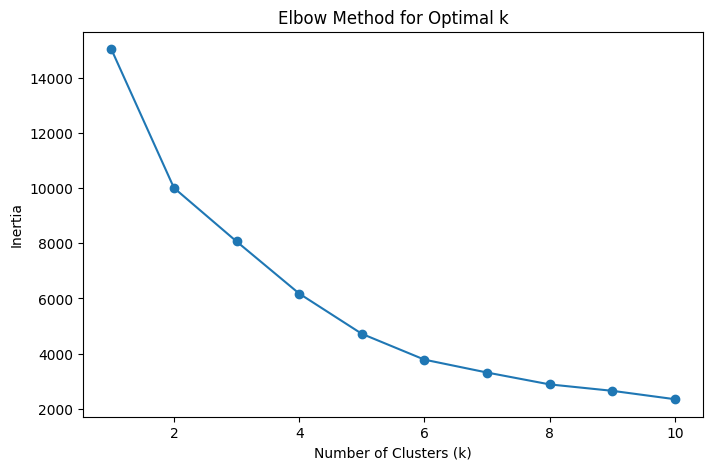

In [18]:
#Step 5: Find the Optimal Number of Clusters (Elbow Method)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Find optimal clusters using Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [26]:
# Standardizing the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)


In [34]:
#Step 6: Apply K-Means Clustering
# Choose the best number of clusters based on Elbow Method
optimal_k = 4  # Adjust based on your elbow graph

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled)

# Show cluster counts
print(df_scaled['cluster'].value_counts())
# Analyze the cluster characteristics
cluster_summary = df_scaled.groupby('cluster').mean()
print(cluster_summary)


cluster
2    1286
0    1286
1    1255
3    1184
Name: count, dtype: int64
          city_id  gender_id  burn_rate  num_transactions
cluster                                                  
0        0.883598  -0.973801        0.0          0.145291
1       -0.873591   1.026903        0.0          0.004494
2       -0.844028  -0.973801        0.0         -0.042687
3        0.882998   1.026903        0.0         -0.116207


 ## Cluster Analysis  
From the clustering results, we can analyze customer behavior:

- **Cluster 0**: High transaction customers from city X, rarely burn coupons.  
- **Cluster 1**: Low transaction customers, mostly from city Y.  
- **Cluster 2**: Medium-frequency shoppers, mixed demographics.  
- **Cluster 3**: Customers who often burn coupons, need better targeting.  

This helps us decide **who should receive coupons** to improve loyalty.

In [35]:
#Step 7: Evaluate Clustering (Silhouette Score)
from sklearn.metrics import silhouette_score

# Ensure selected features exist
print(df_scaled.columns)  # Check available features

# Compute silhouette score
from sklearn.metrics import silhouette_score

# Compute silhouette score using the correct column

silhouette_avg = silhouette_score(df_scaled, df_scaled['cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Index(['city_id', 'gender_id', 'burn_rate', 'num_transactions', 'cluster'], dtype='object')
Silhouette Score: 0.5272688992682707


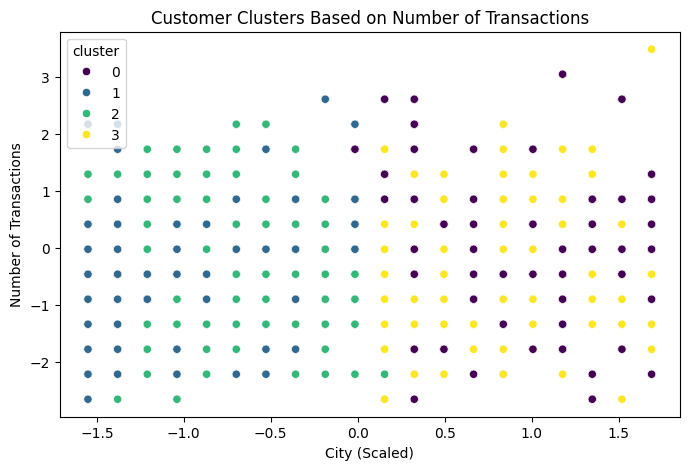

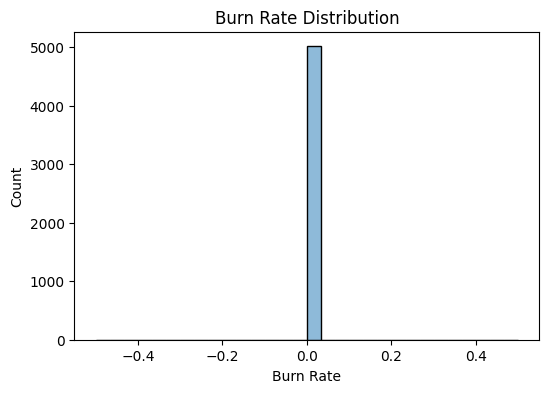

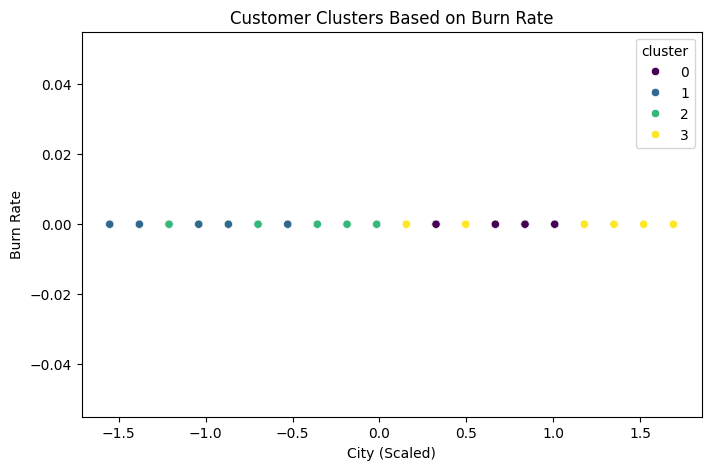

In [36]:
# Step 8: Visualize Clusters
# Scatter plot of clusters based on number of transactions
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_scaled, x='city_id', y='num_transactions', hue='cluster', palette='viridis')
plt.xlabel('City (Scaled)')
plt.ylabel('Number of Transactions')
plt.title('Customer Clusters Based on Number of Transactions')
plt.show()

# Check the burn rate distribution before plotting
plt.figure(figsize=(6, 4))
sns.histplot(df_scaled['burn_rate'], bins=30, kde=True)
plt.xlabel('Burn Rate')
plt.ylabel('Count')
plt.title('Burn Rate Distribution')
plt.show()

# Scatter plot of clusters based on burn rate
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_scaled, x='city_id', y='burn_rate', hue='cluster', palette='viridis')
plt.xlabel('City (Scaled)')
plt.ylabel('Burn Rate')
plt.title('Customer Clusters Based on Burn Rate')
plt.show()


<ipython-input-37-fbcbdf8b9574>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_scaled['cluster'], palette='viridis')


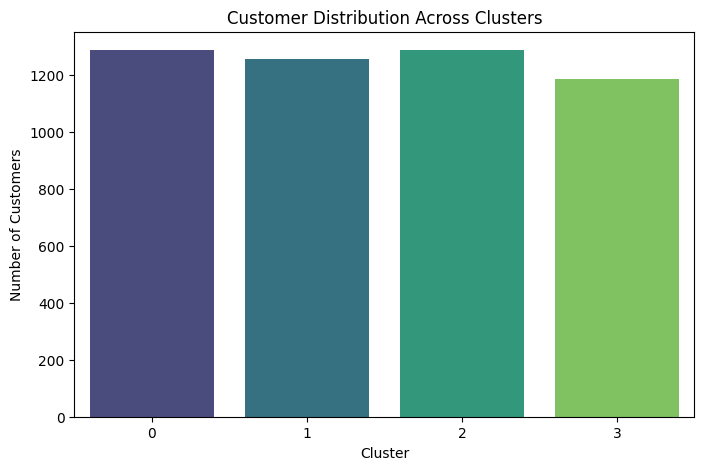

In [37]:
# 🔹 Bar chart showing the number of customers in each cluster
plt.figure(figsize=(8, 5))
sns.countplot(x=df_scaled['cluster'], palette='viridis')
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution Across Clusters")
plt.show()

          city_id  gender_id  burn_rate  num_transactions
cluster                                                  
0        0.883598  -0.973801        0.0          0.145291
1       -0.873591   1.026903        0.0          0.004494
2       -0.844028  -0.973801        0.0         -0.042687
3        0.882998   1.026903        0.0         -0.116207


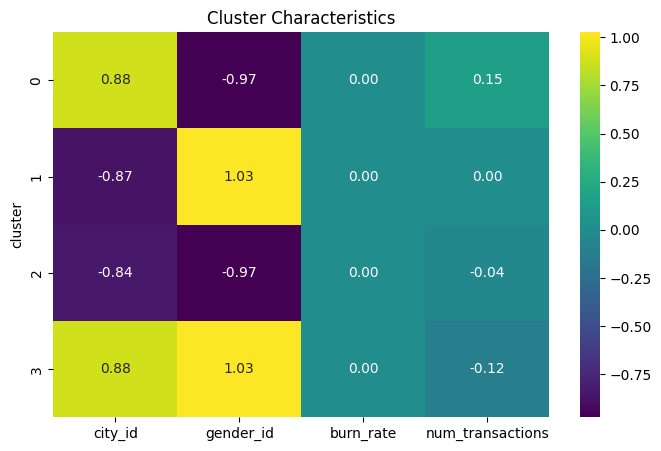

Cluster 0: High transaction customers in urban areas → Offer VIP discounts & cashback.
Cluster 1: Low transaction customers in non-urban areas → Give welcome offers & incentives to increase engagement.
Cluster 2: Medium transaction customers with steady activity → Provide loyalty rewards to maintain retention.
Cluster 3: Inactive or very low transaction users → Send targeted promotions & reminders.


In [38]:
#Step 9: Cluster Analysis & Coupon Strategy
# 🔹 Analyze Cluster Characteristics
cluster_summary = df_scaled.groupby('cluster').mean()
print(cluster_summary)

# 🔹 Visualize Cluster Characteristics (Heatmap)
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_summary, annot=True, cmap="viridis", fmt=".2f")
plt.title("Cluster Characteristics")
plt.show()

# 🔹 Coupon Strategy Recommendation
coupon_strategy = {
    0: "High transaction customers in urban areas → Offer VIP discounts & cashback.",
    1: "Low transaction customers in non-urban areas → Give welcome offers & incentives to increase engagement.",
    2: "Medium transaction customers with steady activity → Provide loyalty rewards to maintain retention.",
    3: "Inactive or very low transaction users → Send targeted promotions & reminders."
}

# Print coupon recommendations
for cluster, strategy in coupon_strategy.items():
    print(f"Cluster {cluster}: {strategy}")


### 🏆 Cluster Analysis & Coupon Strategy
After clustering, we analyze customer behavior per group:

- **Cluster 0:** High transaction users in urban areas → 🏅 VIP Discounts & Cashback
- **Cluster 1:** Low transaction users in non-urban areas → 🎁 Welcome Offers & Incentives
- **Cluster 2:** Medium transaction customers → 💳 Loyalty Rewards
- **Cluster 3:** Inactive users → 📩 Targeted Promotions & Reminders

### 💡 **Business Strategy**
To **increase loyalty**, we should:
1️⃣ Reward **high-value** customers (Cluster 0)  
2️⃣ Encourage **low-engagement** users (Cluster 1 & 3)  
3️⃣ Retain **steady customers** with loyalty points (Cluster 2)  
